In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scienceplots
plt.style.use(['science', 'grid'])

from phd.config import load_config, copy_config
from phd.models.cm.analytical_plate import (
    train, exact_solution,
    plot_results, plot_compare, animate, subsample_frames, 
    load_run, save_run_data, continue_training, 
)
from phd.plot import book_config, get_current_config
book_config.set_as_current()

# Results directory (uses default: results/analytical_plate/{run_name})
save_fig = True

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [2]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===
from phd.config import copy_config, apply_overrides

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 64,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 64,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (displacement)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (displacement)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = train(cfg)
        
        # Save using problem-specific wrapper
        save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed


W1215 08:56:28.712097   70347 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 08:56:28.715827   70231 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


### Forward Results Visualization

In [3]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history

def build_results_df(all_data, config_text_dict=None, append_config=False):
    """Build a summary DataFrame from all_data dict."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        runtime_metrics = entry.get("runtime_metrics", {})
        runtime_metrics["elapsed_time"] /= 60  # convert to minutes
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get formulation from config
        config = entry.get("config", {})
        formulation = config.get("model", {}).get("formulation", "mixed")

        table_cfg = config if append_config else {}
        rows.append({
            "model_name": name,
            "formulation": formulation,
            **final_metrics,
            **runtime_metrics,
            **table_cfg,
        })            

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
if results_forward:
    df_results = build_results_df(results_forward, config_text_dict=config_text_dict)
    display(
        df_results.style
        .background_gradient(subset=["L2 Error"], cmap="Greens_r")
        .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "Stress BC Loss", "Total Loss"])
        .format("{:.2f}", subset=["iterations_per_sec", "elapsed_time"])
        .format("{:.0f}", subset=["net_params_count"])
        .set_properties(subset=["model_name"], **{"text-align": "left"})
    )
else:
    print("No results loaded. Set configs_to_run or ensure saved runs exist.")

,model_name,formulation,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,elapsed_time,iterations_per_sec,net_params_count
0,PINN (displacement),displacement,1.46e-03,4.34e-04,nan,2.63e-04,2.94e-04,7.25,138.00,17154
1,PINN (mixed),mixed,2.45e-03,2.88e-04,8.34e-05,nan,3.73e-04,3.67,272.83,42885
2,SPINN (mixed),mixed,3.04e-03,4.91e-04,2.73e-04,nan,6.04e-04,1.29,773.03,44480
3,SPINN (displacement),displacement,8.57e-03,3.68e-02,nan,9.20e-03,1.42e-02,3.21,311.88,19136


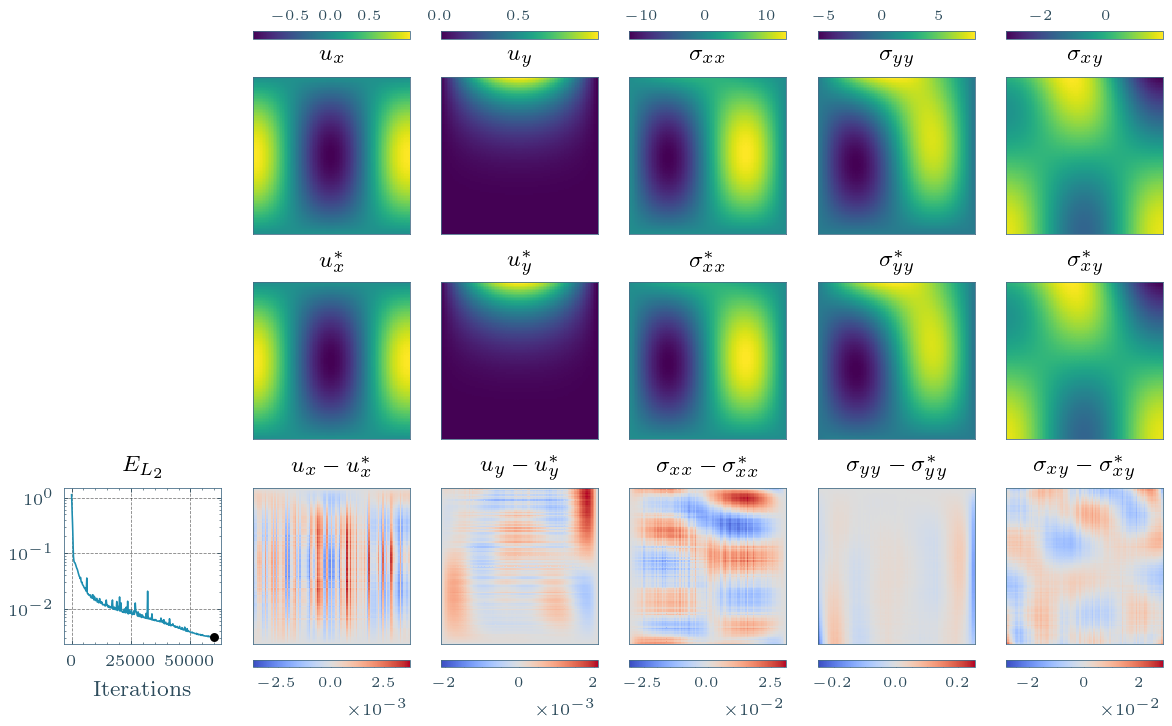

In [4]:
# === Plot single run results ===
from ipywidgets import interact, IntSlider

# Select which run to plot
run_to_plot = "spinn_mixed"  # Change to plot different configs

if run_to_plot in results_forward:
    fig, artists = plot_results(results_forward[run_to_plot], iteration=-1, dpi=200)#, step_type="time", time_unit="sec")
    plt.show()
    
    # Uncomment to enable interactive plotting
    # n_steps = len(results_forward[run_to_plot]["field_saver"].history)
    # @interact(frame_iter=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))
    # def plot_interactive(frame_iter):
    #     fig, artists = plot_results(results_forward[run_to_plot], iteration=frame_iter, dpi=200)
    #     plt.show()
else:
    print(f"Run '{run_to_plot}' not found in results_forward")

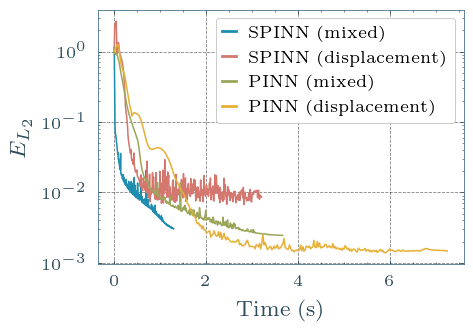

In [ ]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

# Example usage with all forward results
if results_forward:
    fig, ax = plot_metrics_comparison(
        results_forward, 
        metric_name="L2 Error",
        run_names=[config_text_dict.get(k, k) for k in results_forward.keys()],
        step_type="time",
        time_unit="s"
    )

if save_fig:
    

In [ ]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

# Example usage with all forward results
if results_forward:
    plot_metrics_comparison(
        results_forward, 
        metric_name="L2 Error",
        run_names=[config_text_dict.get(k, k) for k in results_forward.keys()],
        step_type="time",
        time_unit="s"
    )

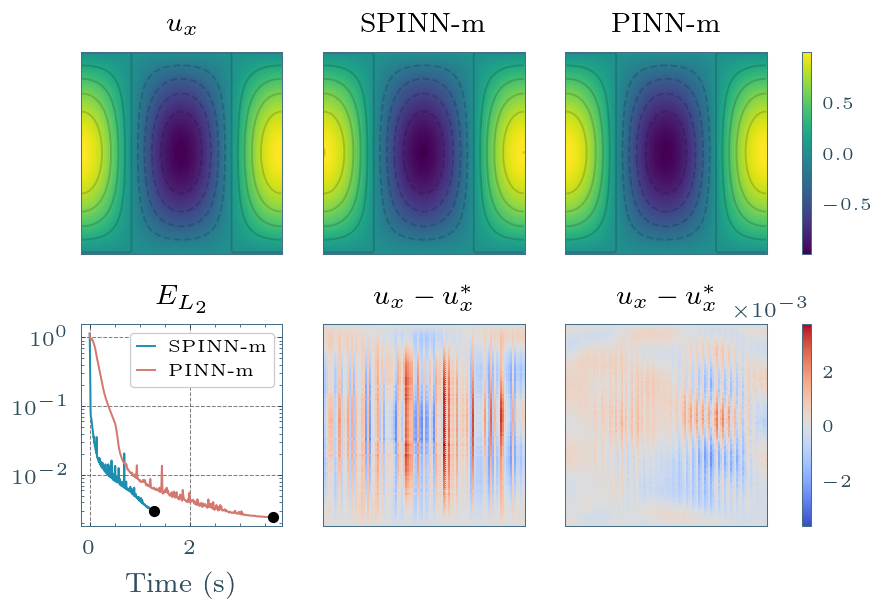

In [8]:
# === Compare SPINN vs PINN (mixed formulation) ===

fields_to_compare = ["spinn_mixed", "pinn_mixed"] # ["spinn_disp", "pinn_disp", "spinn_mixed", "pinn_mixed"]

LATEX_FIELD_NAMES = {
    "spinn_disp": "SPINN-d",
    "pinn_disp": "PINN-d",
    "spinn_mixed": "SPINN-m",
    "pinn_mixed": "PINN-m",
}

get_current_config().min_font_size = 5

if all(field in results_forward for field in fields_to_compare):
    fig, artists = plot_compare(
        results_forward[fields_to_compare[0]],
        results_forward[fields_to_compare[1]],
        exact_solution_fn=exact_solution,
        run_names= [LATEX_FIELD_NAMES[field] for field in fields_to_compare],
        iteration=-1, dpi=250,
        step_type="time", time_unit="sec", plot_contours=True
    )
    plt.show()
    
    if save_fig:
        fig.savefig("_vs_".join(fields_to_compare) + ".png", dpi=300)
else:
    print(f"Need both {fields_to_compare[0]} and {fields_to_compare[1]} to compare")

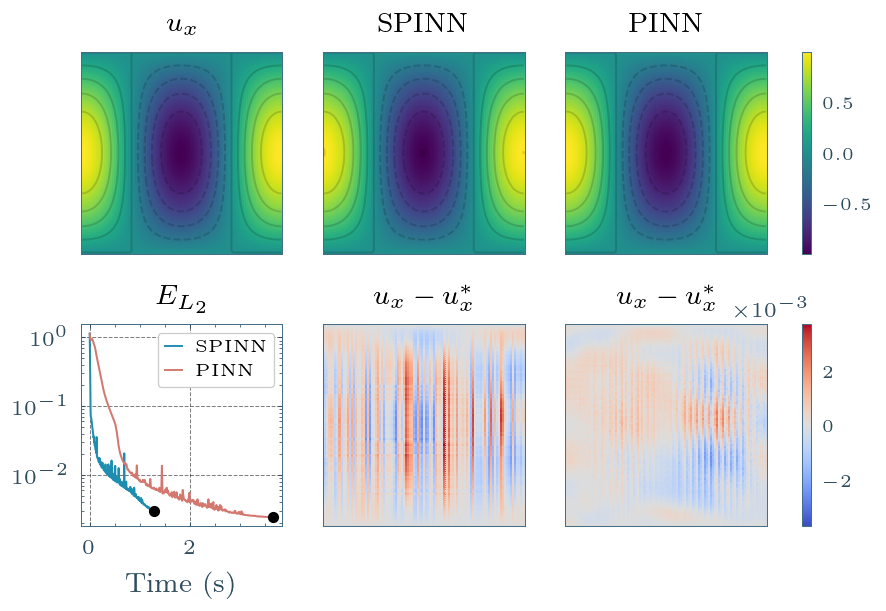

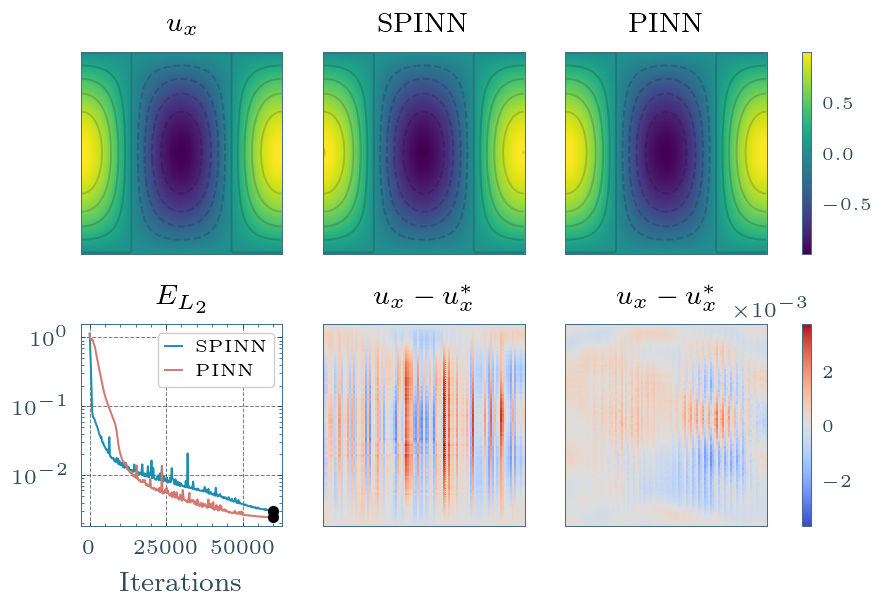

In [12]:
# Plot comparison between SPINN and PINN
fig, artists = plot_compare(
    results_forward["spinn_mixed"], 
    results_forward["pinn_mixed"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
)
# if save_fig:
#     fig.savefig(results_base_dir / "spinn_vs_pinn_time.png", dpi=300)

fig, artists = plot_compare(
    results_forward["spinn_mixed"], 
    results_forward["pinn_mixed"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
)
# if save_fig:
#     fig.savefig(results_base_dir / "spinn_vs_pinn_iter.png", dpi=300)

Subsampled from 300 to 120 frames
Animation preview:
  Total available frames: 300
  Selected frames: 120
  FPS: 10
  Duration: 12.0s


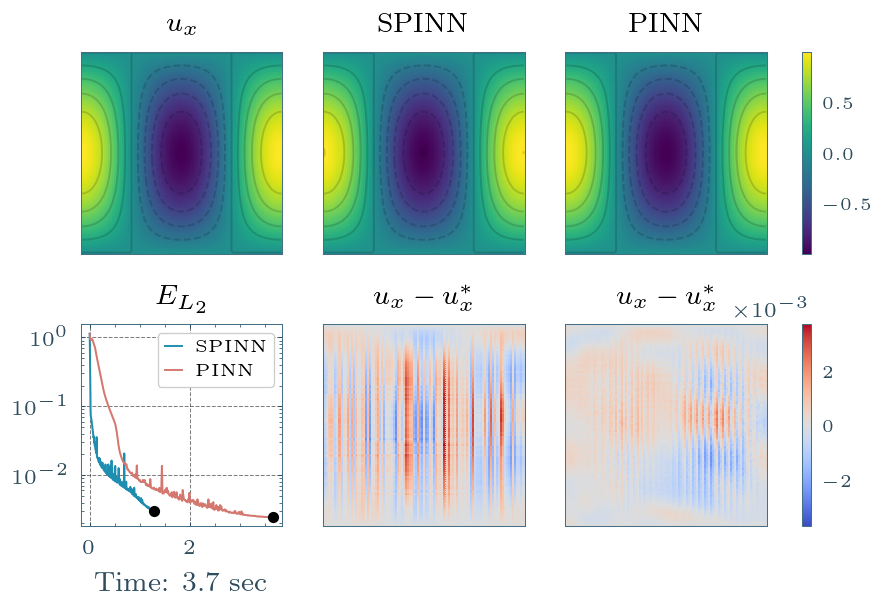

In [14]:
# Generate Animation for comparison
run_dir_forward = Path(results_forward["pinn_mixed"]["run_dir"])
video_path_forward = run_dir_forward / "training_animation.mp4"

fig, artists = plot_compare(
    results_forward["spinn_mixed"], 
    results_forward["pinn_mixed"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
    show_iter=True
)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3,4,4,4,4,4])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
# animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
# Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [2]:
# === Inverse Problem: SPINN/PINN × mixed/displacement + PINN enhanced ===
from phd.config import apply_overrides

# Run configurations to train (empty list = load all from disk)
configs_to_run_inverse = [] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]

# Load base config
base_cfg_inverse = load_config("analytical_plate")
base_cfg_inverse.task.type = "inverse"
base_cfg_inverse.training.n_iter = 60000
base_cfg_inverse.training.log_every = 200
base_cfg_inverse.seed = 0

# Define model variants (only the differences from base)
model_variants_inverse = {
    "spinn_mixed_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 64,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp_inv": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 64,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_enhanced_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 50000, 75000, 1e-5],
        "task.inverse.training_factors.lmbd": 0.1,
        "task.inverse.training_factors.mu": 0.1,
    },
}

all_config_names_inverse = list(model_variants_inverse.keys())
results_inverse = {}

# Text labels for plotting
config_text_dict_inverse = {
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (displacement)",
    "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (displacement)",
    "pinn_enhanced_inv": "PINN (enhanced)",
}

# === Train or Load each configuration ===
for config_name in all_config_names_inverse:
    run_name = config_name
    should_train = config_name in configs_to_run_inverse
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg_inverse)
        apply_overrides(cfg, model_variants_inverse[config_name])
        
        print(f"Training: {run_name}")
        results = train(cfg)
        
        # Save using problem-specific wrapper
        save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_inverse[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_inverse[run_name] = load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed_inv


W1215 09:35:17.725352   71536 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 09:35:17.729257   71419 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp_inv
Loading: pinn_mixed_inv
Loading: pinn_disp_inv
Loading: pinn_enhanced_inv


### Inverse Results Visualization

In [4]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history

def build_inverse_results_df(all_data, config_text_dict=None):
    """Build a summary DataFrame from inverse results."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        runtime_metrics = entry.get("runtime_metrics", {})
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        iters_per_s = entry.get("iterations_per_sec", np.nan)
        elapsed = entry.get("elapsed_time", np.nan)
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get material parameter discovery from variable callback
        var_cb = entry.get("callbacks", {}).get("variable_value", None)
        final_lmbd = np.nan
        final_mu = np.nan
        if var_cb and var_cb.history:
            var_hist = np.array(var_cb.history)
            final_lmbd = var_hist[-1, 1]  # Last value of lambda
            final_mu = var_hist[-1, 2]    # Last value of mu

        rows.append({
            "model_name": name,
            **final_metrics,
            "final_λ": final_lmbd,
            "final_μ": final_mu,
            **runtime_metrics,
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
if results_inverse:
    df_results_inv = build_inverse_results_df(results_inverse, config_text_dict=config_text_dict_inverse)
    display(
        df_results_inv.style
        .background_gradient(subset=["L2 Error"], cmap="Greens_r")
        .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "DIC Loss","Total Loss"])
        .format("{:.4f}", subset=["final_λ", "final_μ"])
        .format("{:.2f}", subset=["iterations_per_sec", "elapsed_time"])
        .format("{:.0f}", subset=["net_params_count"])
        .set_properties(subset=["model_name"], **{"text-align": "left"})
    )
else:
    print("No results loaded. Set configs_to_run_inverse or ensure saved runs exist.")

,model_name,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,DIC Loss,final_λ,final_μ,elapsed_time,iterations_per_sec,net_params_count
0,SPINN (mixed),8.26e-03,3.63e-04,2.13e-04,nan,7.35e-04,5.95e-06,1.0220,0.4934,203.32,295.10,44480
1,SPINN (displacement),1.46e-02,6.12e-03,nan,0.002086,2.62e-03,2.63e-05,0.9828,0.5175,287.71,260.68,nan
2,PINN (displacement),9.22e-02,4.01e-03,nan,0.008258,7.69e-03,1.28e-03,0.8595,0.6329,252.39,297.16,nan
3,PINN (enhanced),4.16e-01,3.73e-03,3.17e-03,nan,3.15e-02,5.91e-03,0.0181,0.9069,258.66,289.95,nan
4,PINN (mixed),1.46e+00,3.73e-04,6.44e-04,nan,1.02e-01,1.82e-02,-2.2903,2.0331,262.83,228.28,42885


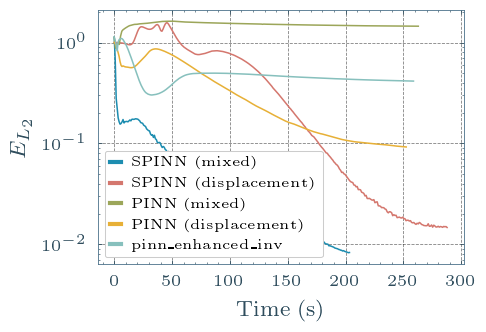

In [9]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

config_text_inv ={
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (displacement)",
    "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (displacement)",
}

if results_inverse:
    plot_metrics_comparison(
        results_inverse,
        metric_name="L2 Error",
        run_names=[config_text_inv.get(k, k) for k in results_inverse.keys()],
        step_type="time",
        time_unit="s"
    )

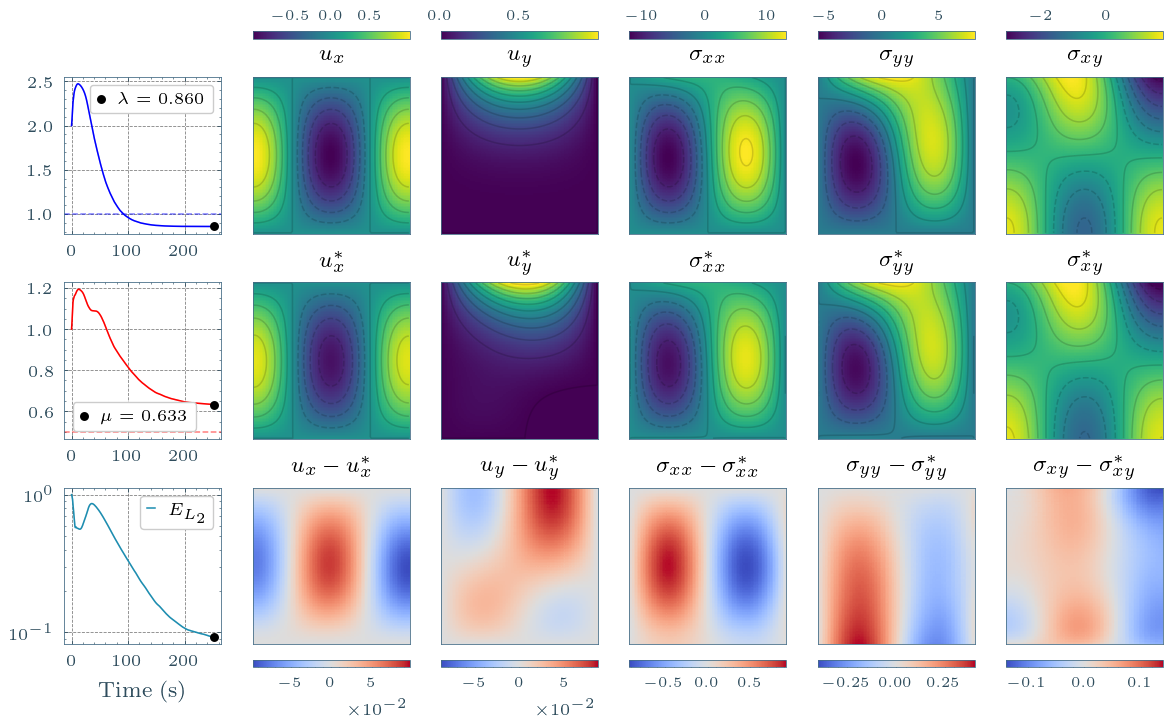

In [11]:
# === Plot single inverse run results ===
run_to_plot = "pinn_disp_inv"  # Change to plot different configs

if run_to_plot in results_inverse:
    step = len(results_inverse[run_to_plot]["losshistory"].steps) - 2
    fig_inv, artists_inv = plot_results(results_inverse[run_to_plot], iteration=step, dpi=200, step_type="time", time_unit="sec", plot_contours=True)

    if save_fig:
        run_dir = Path(results_inverse[run_to_plot]["run_dir"])
        fig_inv.savefig(run_dir / "inverse_results.png", dpi=300)
else:
    print(f"Run '{run_to_plot}' not found in results_inverse")

In [ ]:
# === Generate Animation for Inverse Problem ===
run_to_plot = "spinn_mixed"  # Change to different config for animation

if run_to_plot in results_inverse:
    fig_inv, artists_inv = plot_results(results_inverse[run_to_plot], iteration=0, dpi=200, step_type="time", time_unit="min", show_iter=True)
    
    video_path_inverse = Path(results_inverse[run_to_plot]["run_dir"]) / "training_animation.mp4"
    print("Generating animation...")

    # Custom frame subsampling - more detail at the beginning
    n_frames = len(artists_inv["steps"])
    frame_indices = subsample_frames(n_frames, factors=[1, 2, 3, 4, 5, 5, 5])

    # Preview
    animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices, preview=True)

    # Uncomment to save:
    # animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices)
    # Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")
else:
    print(f"Run '{run_to_plot}' not found in results_inverse")

Generating animation...
Animation preview:
  Total available frames: 300
  Selected frames: 117
  FPS: 10
  Duration: 11.7s
Animation saved to analytical_plate_results/SPINN_inverse/training_animation.mp4 (117 frames, 11.7s)


In [14]:
# Compare parameter evolution: SPINN vs PINN (time-based)
from phd.plot.plot_cm import compute_metrics_from_history

def plot_inverse_evolution(results_data, run_name, ax_lmbd, ax_mu, ax_l2, 
                           lmbd_true=1.0, mu_true=0.5, linestyle='-', color_lmbd='b', color_mu='r'):
    """Plot evolution of lambda, mu and L2 error for a single run.
    
    Returns artists dict containing line and scatter objects for animation.
    """
    d = results_data[run_name]
    elapsed = d.get("elapsed_time", 1.0)
    
    # Get variables history
    var_cb = d.get("variable_value_callback")
    if var_cb and var_cb.history:
        var_hist = np.array(var_cb.history)
        var_steps = var_hist[:, 0]
        lmbd_vals = var_hist[:, 1]
        mu_vals = var_hist[:, 2]
        var_time = var_steps * (elapsed / var_steps[-1]) / 60  # Convert to minutes
    
    # Get metrics history
    metrics = compute_metrics_from_history(d["losshistory"])
    metrics_steps = metrics["steps"]
    l2_vals = metrics["Residual"]
    metrics_time = metrics_steps * (elapsed / metrics_steps[-1]) / 60  # Convert to minutes
    
    # Plot lambda
    ax_lmbd.plot(var_time, lmbd_vals, alpha=0.2, color=color_lmbd)
    lmbd_line, = ax_lmbd.plot([], [], linestyle=linestyle, color=color_lmbd, zorder=3)
    lmbd_scatter = ax_lmbd.scatter([], [], c='k', zorder=4)
    
    # Plot mu
    ax_mu.plot(var_time, mu_vals, alpha=0.2, color=color_mu)
    mu_line, = ax_mu.plot([], [], linestyle=linestyle, color=color_mu, zorder=3)
    mu_scatter = ax_mu.scatter([], [], c='k', zorder=4)
    
    # Plot L2
    ax_l2.plot(metrics_time, l2_vals, alpha=0.2, color=color_lmbd)
    l2_line, = ax_l2.plot([], [], linestyle=linestyle, color=color_lmbd, zorder=3)
    l2_scatter = ax_l2.scatter([], [], c='k', zorder=4)
    
    return {
        "var_time": var_time, "lmbd_vals": lmbd_vals, "mu_vals": mu_vals,
        "metrics_time": metrics_time, "l2_vals": l2_vals,
        "lmbd_line": lmbd_line, "lmbd_scatter": lmbd_scatter,
        "mu_line": mu_line, "mu_scatter": mu_scatter,
        "l2_line": l2_line, "l2_scatter": l2_scatter,
    }


def create_inverse_comparison_figure(spinn_data, pinn_data, 
                                     spinn_run="SPINN_inverse", pinn_run="PINN_inverse",
                                     lmbd_true=1.0, mu_true=0.5,
                                     colors=None, save_path=None):
    """Create a figure comparing SPINN and PINN inverse problem results."""
    from phd.plot import get_current_config, KUL_CYCLE
    
    if colors is None:
        colors = KUL_CYCLE[:2]
    
    # Get elapsed times for axis limits
    spinn_elapsed = spinn_data[spinn_run].get("elapsed_time", 1.0) / 60
    pinn_elapsed = pinn_data[pinn_run].get("elapsed_time", 1.0) / 60
    max_time = max(spinn_elapsed, pinn_elapsed)
    xlim = (0, max_time * 1.05)
    
    # Create figure with 3 rows
    page_width = get_current_config().page_width
    n_subplots = 3
    fig_width_spinn = page_width * 0.5
    axes_width_spinn = fig_width_spinn / n_subplots
    subplot_height = axes_width_spinn
    margin_left = 0.0
    margin_right = 0.0
    x_pad = 0.02 * page_width
    fig_width_both = fig_width_spinn + margin_left + margin_right
    fig_height = subplot_height
    
    fig, axes = plt.subplots(1, n_subplots, figsize=(fig_width_both, fig_height), dpi=200)
    ax_lmbd, ax_mu, ax_l2 = axes
    
    # Plot SPINN
    spinn_art = plot_inverse_evolution(spinn_data, spinn_run, ax_lmbd, ax_mu, ax_l2,
                                       lmbd_true=lmbd_true, mu_true=mu_true,
                                       linestyle='-', color_lmbd=colors[0], color_mu=colors[0])
    
    # Plot PINN
    pinn_art = plot_inverse_evolution(pinn_data, pinn_run, ax_lmbd, ax_mu, ax_l2,
                                      lmbd_true=lmbd_true, mu_true=mu_true,
                                      linestyle='--', color_lmbd=colors[1], color_mu=colors[1])
    
    # Configure lambda axis
    ax_lmbd.axhline(y=lmbd_true, linestyle=':', color='gray', alpha=0.5)
    ax_lmbd.set_xlim(xlim)
    ax_lmbd.set_xlabel("Time (min)")
    ax_lmbd.set_title(r"$\lambda$")
    
    # Configure mu axis
    ax_mu.axhline(y=mu_true, linestyle=':', color='gray', alpha=0.5)
    ax_mu.set_xlim(xlim)
    ax_mu.set_xlabel("Time (min)")
    ax_mu.set_title(r"$\mu$")
    
    # Configure L2 axis
    ax_l2.set_yscale('log')
    ax_l2.set_xlim(xlim)
    ax_l2.set_xlabel("Time (min)")
    ax_l2.set_title(r"$E_{L_2}$")
    
    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=colors[0], linestyle='-', label='SPINN'),
        Line2D([0], [0], color=colors[1], linestyle='--', label='PINN'),
    ]
    ax_l2.legend(handles=legend_elements, loc='upper right', handlelength=1).get_frame().set_linewidth(0.5)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes


# Load data for comparison
spinn_runs = ["spinn_mixed_inv", "spinn_disp_inv"]
pinn_runs = ["pinn_mixed_inv", "pinn_disp_inv"]

spinn_data = {}
for run in spinn_runs:
    try:
        spinn_data[run] = load_run(run)
    except FileNotFoundError:
        print(f"Run {run} not found, skipping...")

pinn_data = {}
for run in pinn_runs:
    try:
        pinn_data[run] = load_run(run)
    except FileNotFoundError:
        print(f"Run {run} not found, skipping...")